In [1]:
from data_processing.neural_networks.DEEP_RL_Deep_Reinforcement_Learning.TRPO_module.TRPO_train import TRPO_train_wrap
from data_processing.neural_networks.DEEP_RL_Deep_Reinforcement_Learning.TRPO_module.TRPO_env import TRPO_env
import torch, matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
# os.environ['MUJOCO_PY_MJKEY_PATH'] = os.path.join('E:','Progs','mjpro131')
# os.environ['MUJOCO_PY_MJPRO_PATH'] = os.path.join('E:','Progs','mjpro131')
from IPython.display import clear_output
clear_output()

In [2]:
from gym_jiminy.envs import AntJiminyEnv
env = AntJiminyEnv(False)
env_params = {'id':'AntJiminyEnv'}

env_CP      = TRPO_env(env, device=device)
trainer     = TRPO_train_wrap(env_CP, actor_hidden=[100,50], critic_hidden = [100,50])
#trainer.init_train_params(eps_per_batch=5,endless=False, max_ep_len=4000)
base_path = os.path.join('data_processing', 'neural_networks', 'DEEP_RL_Deep_Reinforcement_Learning','TRPO_Module','cases','AntJiminyEnv')
case_name = env_params['id'] + '_100_50'
trainer.load_weights(case_name,base_path)

In [52]:
torch.save(trainer.actor.mlp.state_dict(),    os.path.join(base_path,case_name+'_actor.pt'))
torch.save(trainer.critic.state_dict(), os.path.join(base_path,case_name+'_critic.pt'))

In [5]:
trainer.init_train_params(eps_per_batch=5,endless=True, max_ep_len=2000, delta=0.05,critic_iters = 100)

In [51]:
trainer.delta = 0.01
# trainer.critic_iters = 100
trainer.eps_per_batch = 10
trainer.train(num_iters=20)
trainer.save_weights(case_name,base_path)

 35%|███▌      | 7/20 [17:57<33:21, 154.00s/it, 1.avg_cum_reward_mean=1.7e+3, 2.avg_cum_reward_std=31, 3. step_len=0.8, batch_size=2e+4, epoch=9, evals=1070]    


KeyboardInterrupt: 

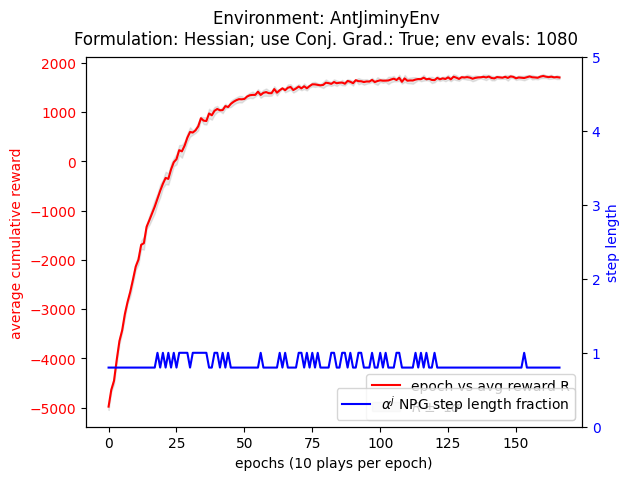

In [53]:
fig, ax1 = plt.subplots()
x = torch.arange(len(trainer.progress))
y1 = torch.tensor(trainer.progress)
y2 = torch.tensor(trainer.progress_std)
ax1.plot(x,y1, label='epoch vs avg reward R', c = 'r')    ;
ax1.fill_between(x, y1 - y2, y1 + y2, color='#888888', alpha=0.2, label='$R\pm$ 1$\sigma$')
ax1.set_xlabel(f'epochs ({trainer.eps_per_batch} plays per epoch)')
ax1.set_ylabel('average cumulative reward', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(x,trainer.step_lengths, c = 'b', label=r'$\alpha^j$ NPG step length fraction')
ax2.set_ylim(0,5)

ax2.set_ylabel('step length', color='b') 
ax2.tick_params(axis='y', labelcolor='b')
ax1.legend()
ax2.legend(loc='lower right')
plt.suptitle(f"Environment: {env_params['id']}\nFormulation: {'Hessian' if not trainer.use_FIM else 'FIM'}; use Conj. Grad.: {trainer.use_CG }; env evals: {env_CP.env_iters}");
plt.savefig(os.path.join(base_path,env_params['id']+'_32_32.png'))

In [ ]:
terminated, truncated = False, False
observation, info = env.reset()
i = 0
while not (terminated or truncated):
    #action = env.action_space.sample()
    action =torch.as_tensor(observation, device=device, dtype = torch.float32)
    action = trainer.actor.get_action(action)
    observation, reward, terminated, truncated, info = env.step(action)
    i+= 1
    if i > 500: break
env.replay()